# freud.order.Steinhardt
## Steinhardt Order Parameters
The `freud.order` module provids the tools to calculate various [order parameters](https://en.wikipedia.org/wiki/Phase_transition#Order_parameters) that can be used to identify phase transitions.
In the context of crystalline systems, some of the best known order parameters are the Steinhardt order parameters $q_l$ and $w_l$.
These order parameters are mathematically defined according to certain rotationally invariant combinations of spherical harmonics calculated between particles and their nearest neighbors, so they provide information about local particle environments.
As a result, considering distributions of these order parameters across a system can help characterize the overall system's ordering.
The primary utility of these order parameters arises from the fact that they often exhibit certain characteristic values for specific crystal structures.

In this notebook, we will use the order parameters to identify certain basic structures: BCC, FCC, and simple cubic.
FCC, BCC, and simple cubic structures each exhibit characteristic values of $q_l$ for some $l$ value, meaning that in a perfect crystal all the particles in one of these structures will have the same value of $q_l$.
As a result, we can use these characteristic $q_l$ values to determine whether a disordered fluid is beginning to crystallize into one structure or another.
The $l$ values correspond to the $l$ quantum number used in defining the underlying spherical harmonics; for example, the $q_4$ order parameter would provide a measure of 4-fold ordering. 

In [1]:
import freud
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Try to plot using KDE if available, otherwise revert to histogram
try:
    from sklearn.neighbors.kde import KernelDensity

    kde = True
except:
    kde = False

np.random.seed(1)

We first construct ideal crystals and then extract the characteristic value of $q_l$ for each of these structures.
In this case, we know that simple cubic has a coordination number of 6, BCC has 8, and FCC has 12, so we are looking for the values of $q_6$, $q_8$, and $q_{12}$, respectively.
Therefore, we can also enforce that we require 6, 8, and 12 nearest neighbors to be included in the calculation, respectively.

In [2]:
L = 6
sc = freud.data.UnitCell.sc()
sc_system = sc.generate_system(5)
ql = freud.order.Steinhardt(L)
ql_sc = ql.compute(sc_system, neighbors={"num_neighbors": L}).particle_order
mean_sc = np.mean(ql_sc)
print(
    "The Q{} values computed for simple cubic are {:.3f} +/- {:.3e}".format(
        L, mean_sc, np.std(ql_sc)
    )
)

L = 8
bcc = freud.data.UnitCell.bcc()
bcc_system = bcc.generate_system(5, sigma_noise=0)
ql = freud.order.Steinhardt(L)
ql.compute(bcc_system, neighbors={"num_neighbors": L})
ql_bcc = ql.particle_order
mean_bcc = np.mean(ql_bcc)
print(
    "The Q{} values computed for bcc are {:.3f} +/- {:.3e}".format(
        L, mean_bcc, np.std(ql_bcc)
    )
)

L = 12
fcc = freud.data.UnitCell.fcc()
fcc_system = fcc.generate_system(5)
ql = freud.order.Steinhardt(L)
ql_fcc = ql.compute(fcc_system, neighbors={"num_neighbors": L}).particle_order
mean_fcc = np.mean(ql_fcc)
print(
    "The Q{} values computed for fcc are {:.3f} +/- {:.3e}".format(
        L, mean_fcc, np.std(ql_fcc)
    )
)

The Q6 values computed for simple cubic are 0.354 +/- 3.938e-08
The Q8 values computed for bcc are 0.213 +/- 1.137e-12
The Q12 values computed for fcc are 0.600 +/- 1.155e-12


Given that the per-particle order parameter values are essentially identical to within machine precision, we can be confident that we have found the characteristic value of $q_l$ for each of these systems.
We can now compare these values to the values of $q_l$ in thermalized systems to determine the extent to which they are exhibiting the ordering expected of one of these perfect crystals.

In [3]:
def make_noisy_replicas(unitcell, sigmas):
    """Given a unit cell, return a noisy system."""
    systems = []
    for sigma in sigmas:
        systems.append(unitcell.generate_system(5, sigma_noise=sigma))
    return systems

In [4]:
sigmas = [0.01, 0.02, 0.03, 0.05]
sc_systems = make_noisy_replicas(sc, sigmas)
bcc_systems = make_noisy_replicas(bcc, sigmas)
fcc_systems = make_noisy_replicas(fcc, sigmas)

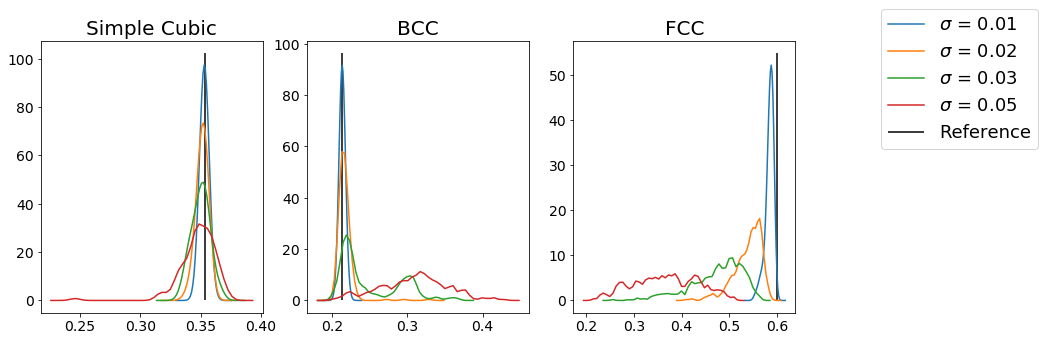

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Zip up the data that will be needed for each structure type.
zip_obj = zip(
    [sc_systems, bcc_systems, fcc_systems],
    [mean_sc, mean_bcc, mean_fcc],
    [6, 8, 12],
    ["Simple Cubic", "BCC", "FCC"],
)

for i, (systems, ref_val, L, title) in enumerate(zip_obj):
    ax = axes[i]
    for j, (system, sigma) in enumerate(zip(systems, sigmas)):
        ql = freud.order.Steinhardt(L)
        ql.compute(system, neighbors={"num_neighbors": L})
        if not kde:
            ax.hist(ql.particle_order, label=rf"$\sigma$ = {sigma}", density=True)
        else:
            padding = 0.02
            N = 50
            bins = np.linspace(
                np.min(ql.particle_order) - padding,
                np.max(ql.particle_order) + padding,
                N,
            )

            kde = KernelDensity(bandwidth=0.004)
            kde.fit(ql.particle_order[:, np.newaxis])
            ql = np.exp(kde.score_samples(bins[:, np.newaxis]))

            ax.plot(bins, ql, label=rf"$\sigma$ = {sigma}")
        ax.set_title(title, fontsize=20)
        ax.tick_params(axis="both", which="both", labelsize=14)
        if j == 0:
            # Can choose any element, all are identical in the reference case
            ax.vlines(ref_val, 0, np.max(ax.get_ylim()[1]), label="Reference")
fig.legend(*ax.get_legend_handles_labels(), fontsize=18)  # Only have one legend
fig.subplots_adjust(right=0.78)

From this figure, we can see that for each type of structure, increasing the amount of noise makes the distribution of the order parameter values less peaked at the expected reference value.
As a result, we can use this method to identify specific structures.
Choosing the appropriate parameterization for the order parameter (which quantum number $l$ to use, how to choose neighbors, etc.) can be very important.

In addition to the $q_l$ parameters demonstrated here, this class can also compute the third-order invariant $w_l$.
The $w_l$ may be better at identifying some structures, so some experimentation and reference to the appropriate literature can be useful (as a starting point, see [Steinhardt, Nelson, and Ronchetti (1983)](https://doi.org/10.1103/PhysRevB.28.784)).

By setting `average=True` in the constructor, the `Steinhardt` class will perform an additional level of averaging over the second neighbor shells of particles, to accumulate more information on particle environments (see [Lechner and Dellago (2008)](https://doi.org/10.1063/1.2977970)).
To get a sense for the best method for analyzing a specific system, the best course of action is try out different parameters or to consult the literature to see how these have been used in the past.